4.  Entrenar una red neuronal que de la solucion de las siguientes ecuaciones diferenciales en el el intervalo [-5,5].  
Graficar la solucion numerica junto con la solucion analitica.

(b) d^2y/dx^2 =−y con y(0) = 1, y(0) = −0.5

In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop, Adam 

from matplotlib import pyplot as plt 
import numpy as np 
import math

In [3]:
class ODEsolver(Sequential): 
    def __init__(self, **kwargs): 
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss") #funcion de costo
        self.mse = tf.keras.losses.MeanSquaredError()
        
    @property 
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data): #define el paso de entrenamiento
        batch_size = tf.shape(data)[0]
        x = tf.random.uniform((batch_size, 1), minval = -5, maxval = 5)
        
        with tf.GradientTape() as tape: #calcula las derivadas 
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                
                with tf.GradientTape(persistent=True) as tape3: 
                    tape3.watch(x)
                    x_o = tf.zeros((batch_size, 1))
                    tape3.watch(x_o)
                    y_pred = self(x, training = True)
                    y_o = self(x_o, training = True)
                    
                dy = tape3.gradient(y_pred, x)
                dy_o = tape3.gradient(y_o, x_o)
            #vectores de ceros
            dy_2=tape2.gradient(dy,x)
            eq = dy_2 + y_pred #función de costos 
            
            ic = y_o -1. #condiciones iniciales
            ic_2 = dy_o 
            loss = keras.losses.mean_squared_error(0., eq) + keras.losses.mean_squared_error(0., ic) + keras.losses.mean_squared_error(-0.5,ic_2)
    # Calcular gradientes y aplicarlo
        grads =tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return  {"loss": self.loss_tracker.result()}

In [4]:
mse = tf.keras.losses.MeanSquaredError()
mse([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [5]:
keras.losses.mean_squared_error([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 16])>

In [6]:
# Crear una instancia de la clase ODEsolver
model = ODEsolver()

# Definir las capas de la red neuronal
model.add(Dense(30, activation='tanh', input_shape=(1,)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation ="linear"))

# Imprimir un resumen del modelo
model.compile(optimizer='RMSprop', metrics=['loss']) 
model.summary()

Model: "od_esolver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 20)                220       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 811 (3.17 KB)
Trainable params: 811 (3.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
x = tf.linspace(-5.0, 5.0, 100)# Generar datos de entrada en el rango [-5, 5]
history = model.fit(x, epochs=1000, verbose=0)# Entrenar el modelo durante 1000 épocas 

4/4 [==============================] - 1s 4ms/step


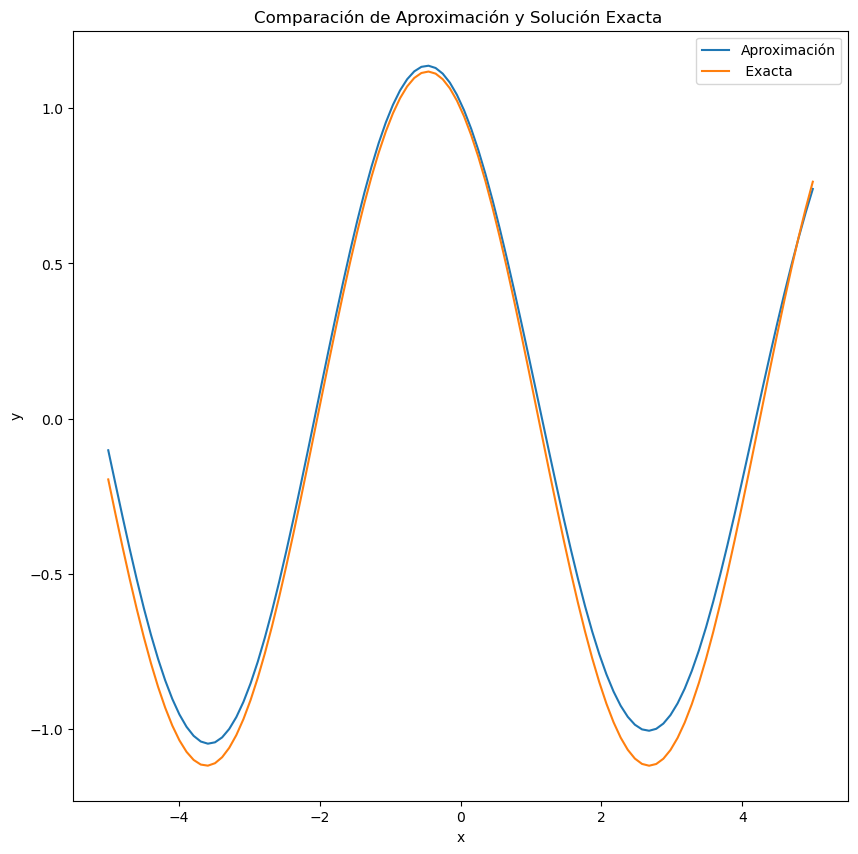

In [8]:
x_testv = tf.linspace(-5,5,100)# Generar datos de prueba en el rango [-5, 5] 
a=model.predict(x_testv)# Obtener las predicciones del modelo
exact_solution =tf.cos(x) - 0.5*tf.sin(x) # solución exacta

# Graficar las predicciones y la solución exacta
plt.figure(figsize = (10,10))
plt.plot(x_testv, a, label="Aproximación")
plt.plot(x_testv, exact_solution, label=" Exacta")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparación de Aproximación y Solución Exacta ')
plt.show()